
# Filtering and Restoration PW


In [47]:

# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from skimage import io as skio
from scipy import ndimage as ndi

# Utility Functions
def viewimage(im, normalise=False, MINI=0.0, MAXI=255.0):
    """Display the image in grayscale."""
    imt = np.float32(im.copy())
    if normalise:
        imt = (imt - imt.min()) * 255 / (imt.max() - imt.min())
    else:
        imt = (imt - MINI) * 255 / (MAXI - MINI)
        imt[imt < 0] = 0
        imt[imt > 255] = 255
    plt.imshow(imt, cmap='gray')
    plt.axis('off')
    plt.show()

def noise(im, br):
    """Add Gaussian noise to the image."""
    return np.float32(im) + br * np.random.randn(*im.shape)

def Get_values_without_error(im,XX,YY):
    """ retouren une image de la taille de XX et YY 
     qui vaut im[XX,YY] mais en faisant attention a ce que XX et YY ne debordent
     pas """
    sh=XX.shape
    defaultval=0
    if len(im.shape)>2:
        defaultval=np.asarray([0,0,0])
        sh=[*sh,im.shape[2]]
    imout=np.zeros(sh)
    (ty,tx)=XX.shape[0:2]
    for k in range(ty):
        for l in range(tx):
            posx=int(XX[k,l]-0.5)
            posy=int(YY[k,l]-0.5)
            if posx<0 or posx>=im.shape[1] or posy<0 or posy>=im.shape[0]:
                valtmp=defaultval
            else:
                valtmp=im[posy,posx]
            imout[k,l]=valtmp
    
    return imout

def rotation(im,theta,alpha=1.0,x0=None,y0=None,ech=0,clip=True):
    """
    x' = alpha*cos(theta)*(x-x0) - alpha*sin(theta)*(y-y0) + x0
    y' = alpha*sin(theta)*(x-x0) + alpha*cos(theta)*(y-y0) + y0 
    """ 
    dy=im.shape[0]
    dx=im.shape[1]
    
    if x0 is None:
        x0=dx/2.0
    if y0 is None:
        y0=dy/2.0
    v0=np.asarray([x0,y0]).reshape((2,1))
    theta=theta/180*np.pi
    ct=alpha*np.cos(theta)
    st=alpha*np.sin(theta)
    matdirect=np.asarray([[ct,-st],[st,ct]])
    if clip==False:
        tabextreme=np.asarray([[0,0,dx,dx],[0,dy,0,dy]])
        tabextreme_trans= matdirect@(tabextreme-v0)+v0
        xmin=np.floor(tabextreme_trans[0].min())
        xmax=np.ceil(tabextreme_trans[0].max())
        ymin=np.floor(tabextreme_trans[1].min())
        ymax=np.ceil(tabextreme_trans[1].max())
        
    else:
        xmin=0
        xmax=dx
        ymin=0
        ymax=dy
    if len(im.shape)>2:
        shout=(int(ymax-ymin),int(xmax-xmin),im.shape[2]) # image couleur
    else:
        shout=(int(ymax-ymin),int(xmax-xmin))
    dyout=shout[0]
    dxout=shout[1]
    eps=0.0001
    Xout=np.arange(xmin+0.5,xmax-0.5+eps)
    Xout=np.ones((dyout,1))@Xout.reshape((1,-1)) 
    
    Yout=np.arange(ymin+0.5,ymax-0.5+eps)
    Yout=Yout.reshape((-1,1))@np.ones((1,dxout))
    
    XY=np.concatenate((Xout.reshape((1,-1)),Yout.reshape((1,-1))),axis=0)
    XY=np.linalg.inv(matdirect)@(XY-v0)+v0
    Xout=XY[0,:].reshape(shout)
    Yout=XY[1,:].reshape(shout)
    if ech==0: # nearest neighbour
        out=Get_values_without_error(im,Xout,Yout)
    else:  # bilinear 
        assert ech == 1 , "you chose unknown sampling"
        Y0=np.floor(Yout-0.5)+0.5 
        X0=np.floor(Xout-0.5)+0.5
        Y1=np.ceil(Yout-0.5)+0.5
        X1=np.ceil(Xout-0.5)+0.5
        PoidsX=Xout-X0
        PoidsY=Yout-Y0
        PoidsX[X0==X1]=1
        PoidsY[Y0==Y1]=1
        I00=Get_values_without_error(im,X0,Y0)
        I01=Get_values_without_error(im,X0,Y1)
        I10=Get_values_without_error(im,X1,Y0)
        I11=Get_values_without_error(im,X1,Y1)
        out=I00*(1.0-PoidsX)*(1.0-PoidsY)+I01*(1-PoidsX)*PoidsY+I10*PoidsX*(1-PoidsY)+I11*PoidsX*PoidsY
    return out

def get_gau_ker(s):
    ss=int(max(3,2*np.round(2.5*s)+1))
    ms=(ss-1)//2
    X=np.arange(-ms,ms+0.99)
    y=np.exp(-X**2/2/s**2)
    out=y.reshape((ss,1))@y.reshape((1,ss))
    out=out/out.sum()
    return out

def get_cst_ker(t):
    return np.ones((t,t))/t**2

def filtre_lineaire(im,ker):
    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    (y,x)=im.shape
    (ym,xm)=ker.shape
    mm=np.zeros((y,x))
    mm[:ym,:xm]=ker
    fout=(fft2(im)*fft2(mm))
    mm[:ym,:xm]=0
    y2=int(np.round(ym/2-0.5))
    x2=int(np.round(xm/2-0.5))
    mm[y2,x2]=1
    out=np.real(ifft2(fout*np.conj(fft2(mm))))
    return out

def filtre_inverse(im,ker):
    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    (y,x)=im.shape
    (ym,xm)=ker.shape
    mm=np.zeros((y,x))
    mm[:ym,:xm]=ker
    fout=(fft2(im)/fft2(mm))
    mm[:ym,:xm]=0
    y2=int(np.round(ym/2-0.5))
    x2=int(np.round(xm/2-0.5))
    mm[y2,x2]=1
    out=np.real(ifft2(fout*(fft2(mm))))
    return out


def median_filter(im,typ=1,r=1,xy=None):
    lx=[]
    ly=[]
    (ty,tx)=im.shape
    if typ==1: #carre
        
        for k in range(-r,r+1):
            for l in range(-r,r+1):
                lx.append(k)
                ly.append(l)
        
    elif typ==2:
        for k in range(-r,r+1):
            for l in range(-r,r+1):
                if k**2+l**2<=r**2:
                    lx.append(k)
                    ly.append(l)
    else: #freeshape
        lx,ly=xy
    
    debx=-min(lx) #min is supposed negative
    deby=-min(ly)
    finx=tx-max(lx) #max is supposed positive
    finy=ty-max(ly)
    ttx=finx-debx
    tty=finy-deby
    tab=np.zeros((len(lx),ttx*tty))
    for k in range(len(lx)):
        tab[k,:]=im[deby+ly[k]:deby+tty+ly[k],debx+lx[k]:debx+ttx+lx[k]].reshape(-1)
    out=im.copy()
    out[deby:finy,debx:finx]=np.median(tab,axis=0).reshape((tty,ttx))
    return out

def wiener(im,K,lamb=0):
    """effectue un filtrage de wiener de l'image im par le filtre K.
       lamb=0 donne le filtre inverse
       on rappelle que le filtre de Wiener est une tentaive d'inversion du noyau K
       avec une regularisation qui permet de ne pas trop augmenter le bruit.
       """
    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    (ty,tx)=im.shape
    (yK,xK)=K.shape
    KK=np.zeros((ty,tx))
    KK[:yK,:xK]=K
    x2=tx/2
    y2=ty/2
    
    fX=np.concatenate((np.arange(0,x2+0.99),np.arange(-x2+1,-0.1)))
    fY=np.concatenate((np.arange(0,y2+0.99),np.arange(-y2+1,-0.1)))
    fX=np.ones((ty,1))@fX.reshape((1,-1))
    fY=fY.reshape((-1,1))@np.ones((1,tx))
    fX=fX/tx
    fY=fY/ty
    
    w2=fX**2+fY**2
    w=w2**0.5
    
    g=fft2(im)
    k=fft2(KK)
    mul=np.conj(k)/(abs(k)**2+lamb*w)
    fout=g*mul
    
    mm=np.zeros((ty,tx))
    y2=int(np.round(yK/2-0.5))
    x2=int(np.round(xK/2-0.5))
    mm[y2,x2]=1
    out=np.real(ifft2(fout*(fft2(mm))))
    return out

def var_image(im,x0,y0,x1,y1):
    patch=im[y0:y1+1,x0:x1+1]
    return patch.var()


## Geometric Transformations

We explore the effects of rotation and scaling on images, and compare nearest-neighbor and bilinear interpolation methods.


8 times 45° rotations with nearest neighbour interpolation :


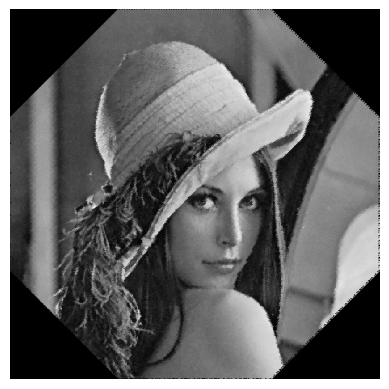

8 times 45° rotations with bilinear interpolation :


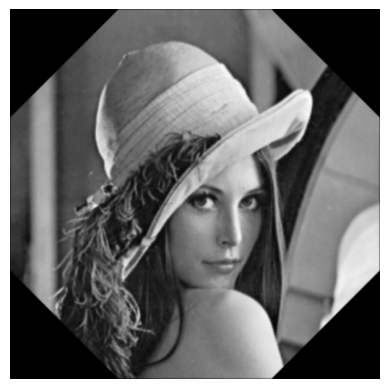

45° rotation and 2x dezoom without gaussian filtering :


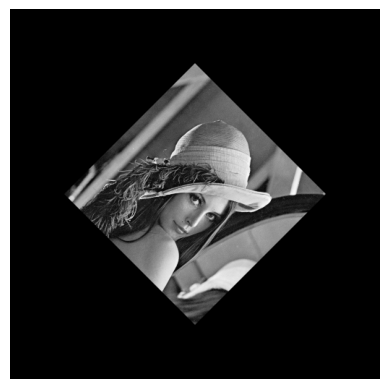

We can see aliasing
45° rotation and 2x dezoom with gaussian filtering :


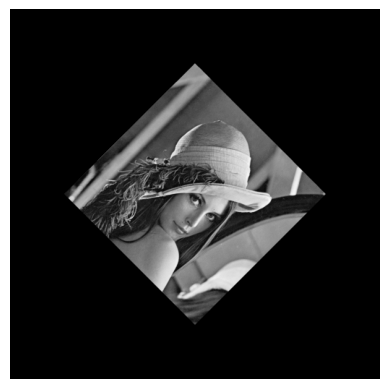

There is no more aliasing but the image is a bit blurred


In [48]:
# Load an image
image_path = 'images/lena.tif'
im_nearest_neighbour = skio.imread(image_path)
im_bilinear = skio.imread(image_path)

# Apply rotations
for i in range(8):
    im_nearest_neighbour = rotation(im_nearest_neighbour,45,ech=0)
    im_bilinear = rotation(im_bilinear,45,ech=1)

# Display results
print('8 times 45° rotations with nearest neighbour interpolation :')
viewimage(im_nearest_neighbour)
print('8 times 45° rotations with bilinear interpolation :')
viewimage(im_bilinear)

# Apply rotation + dezoom
im = skio.imread(image_path)
im_low_pass = filtre_lineaire(im,get_cst_ker(2))

print('45° rotation and 2x dezoom without gaussian filtering :')
viewimage(rotation(im,45,alpha=1/2,ech=1))
print('We can see aliasing')
print('45° rotation and 2x dezoom with gaussian filtering :')
viewimage(rotation(im_low_pass,45,alpha=1/2,ech=1))
print('There is no more aliasing but the image is a bit blurred')


## Filtering Techniques

This section compares linear and median filtering methods, and examines their effects on noisy images.


Noisy Image (Additive Noise) :


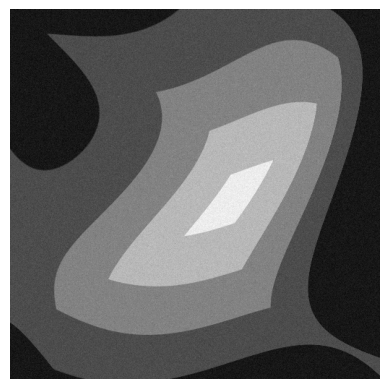

Linear filtering with constant kernel :


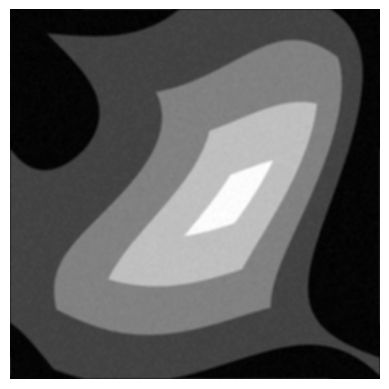

Linear filtering with gaussian kernel :


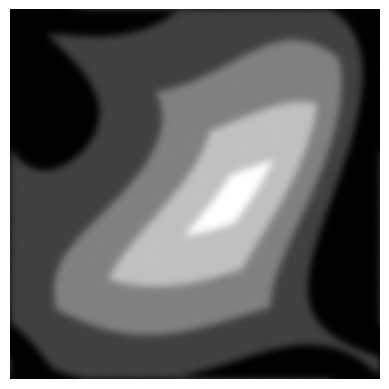

Median filtering :


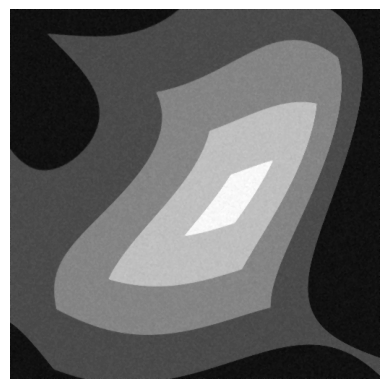

We can see that linear filtering is better for denoising additive noise
Noisy Image (Impulsive Noise) :


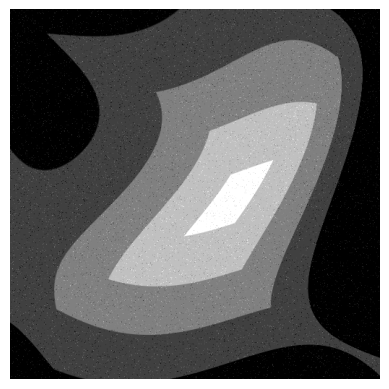

Linear filtering with constant kernel :


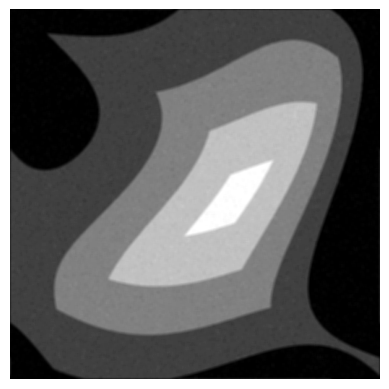

Linear filtering with gaussian kernel :


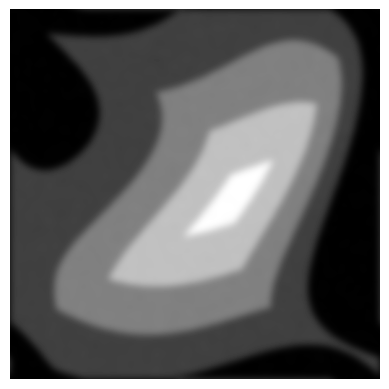

Median filtering :


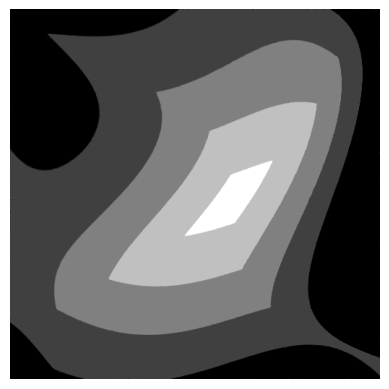

We can see that linear filtering is better for denoising additive noise


In [49]:
# Generate Gaussian and constant kernels
gaussian_kernel = get_gau_ker(5)
constant_kernel = get_cst_ker(5)

# Linear vs median filters for additive noise
im = skio.imread('images/pyramide.tif')
additive_noise_image = noise(im, 5)
linear_filtered_cst = filtre_lineaire(additive_noise_image, constant_kernel)
linear_filtered_gau = filtre_lineaire(additive_noise_image, gaussian_kernel)
median_filtered = median_filter(additive_noise_image)

# Display results
print('Noisy Image (Additive Noise) :')
viewimage(additive_noise_image)
print('Linear filtering with constant kernel :')
viewimage(linear_filtered_cst)
print('Linear filtering with gaussian kernel :')
viewimage(linear_filtered_gau)
print('Median filtering :')
viewimage(median_filtered)
print('We can see that linear filtering is better for denoising additive noise')

# Linear vs median filters for impulsive noise
impulse_noise_image = skio.imread('images/pyra-impulse.tif')
linear_filtered_cst = filtre_lineaire(impulse_noise_image, constant_kernel)
linear_filtered_gau = filtre_lineaire(impulse_noise_image, gaussian_kernel)
median_filtered = median_filter(impulse_noise_image)

# Display results
print('Noisy Image (Impulsive Noise) :')
viewimage(impulse_noise_image)
print('Linear filtering with constant kernel :')
viewimage(linear_filtered_cst)
print('Linear filtering with gaussian kernel :')
viewimage(linear_filtered_gau)
print('Median filtering :')
viewimage(median_filtered)
print('We can see that linear filtering is better for denoising additive noise')

## Equivalent linear and median denoising filters

This section introduces two methods for determining the size of a constant kernel that achieves denoising performance equivalent to that of a median filter.

In [57]:
# method 1
im=skio.imread('images/carre_orig.tif')
im_noise = noise(im,5)

def bruit_img(im,l,h):
    var_min = float('inf')
    for i in range(im.shape[0]-h):
        for k in range(im.shape[1]-l):
            if var_image(im,k,i,k+l,i+h) < var_min:
                var_min = var_image(im,k,i,k+l,i+h)
    return var_min


l,h = 10,10
var_median_4 = bruit_img(median_filter(im_noise,2,4),l,h)
ecart_min = float('inf')
taille_min = 0
for i in range(1,10):
    var_cst = bruit_img(filtre_lineaire(im_noise,get_cst_ker(i)),l,h)
    if abs(var_cst-var_median_4) < ecart_min:
        ecart_min = abs(var_cst-var_median_4)
        taille_min = i
print('Size kernel :',taille_min)

Size kernel : 7


In [56]:
# method 2
im=skio.imread('images/carre_orig.tif')
im_noise = noise(im,5)

var_median_4 = var_image(median_filter(im_noise,2,4),99+3,99+3,155-3,155-3)
ecart_min = float('inf')
taille_min = 0
for i in range(1,28):
    var_cst = var_image(filtre_lineaire(im_noise,get_cst_ker(i)),99+i-1,99+i-1,155-i+1,155-i+1)
    if abs(var_cst-var_median_4) < ecart_min:
        ecart_min = abs(var_cst-var_median_4)
        taille_min = i
print('Size kernel :',taille_min)

Size kernel : 6


## Inverse Filtering Techniques

This section illustrates the impact of noise on inverse filtering performance.

Original image :


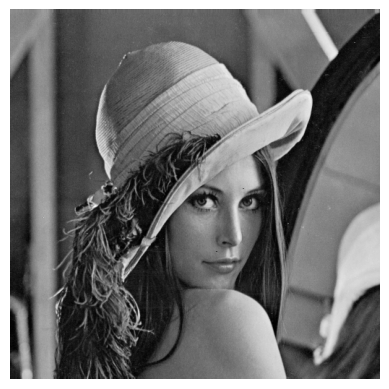

Linear filtered image :


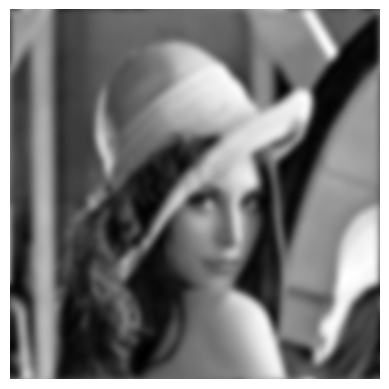

Inverse filtered image :


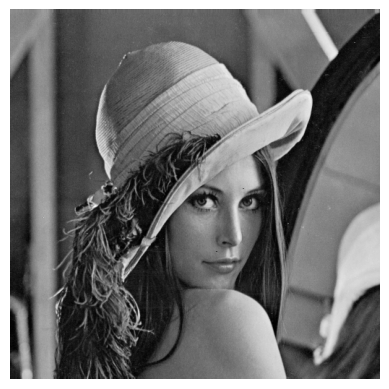

Linear filtered noisy image :


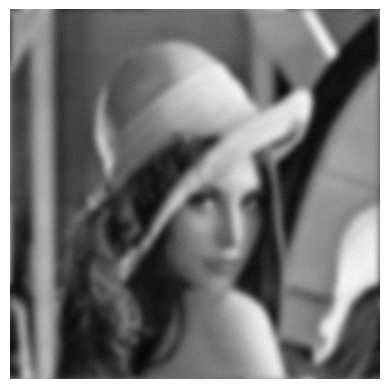

Inverse filtered noisy image :


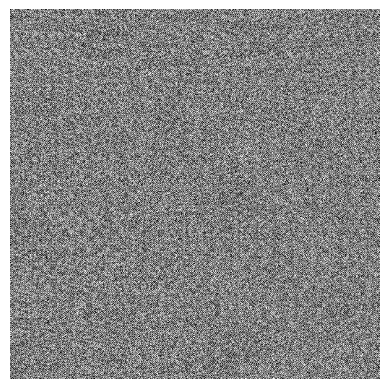

In [52]:
im = skio.imread('images/lena.tif')
print('Original image :')
viewimage(im)

gau_ker = get_gau_ker(5)
im_filtered = filtre_lineaire(im, gau_ker)
print('Linear filtered image :')
viewimage(im_filtered)

print('Inverse filtered image :')
viewimage(filtre_inverse(im_filtered,gau_ker))

im_filtree_noisy = noise(im_filtered,3)
print('Linear filtered noisy image :')
viewimage(im_filtree_noisy)
print('Inverse filtered noisy image :')
viewimage(filtre_inverse(im_filtree_noisy,gau_ker))

## Wiener Restoration
This section explores image restoration using the Wiener filter, demonstrating its effectiveness in mitigating noise and recovering details from a degraded image.

Original image :


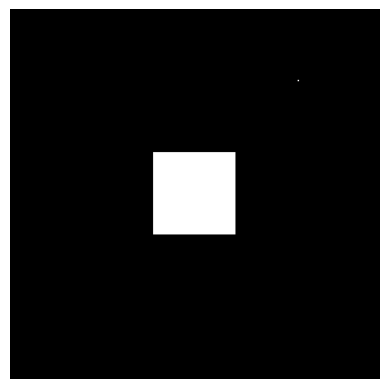

Filtered image :


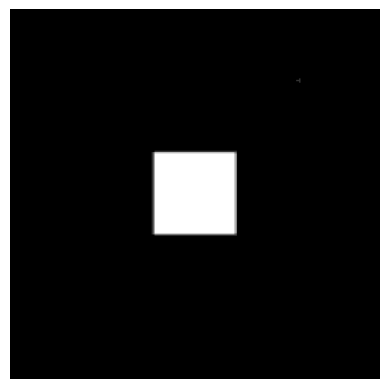

Convolutional kernel :


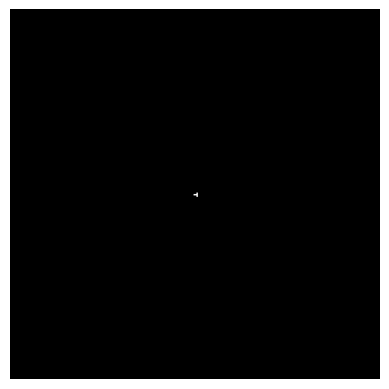

Noisy filtered image :


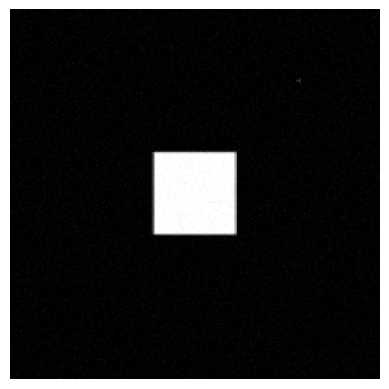

Wiener Restoration :


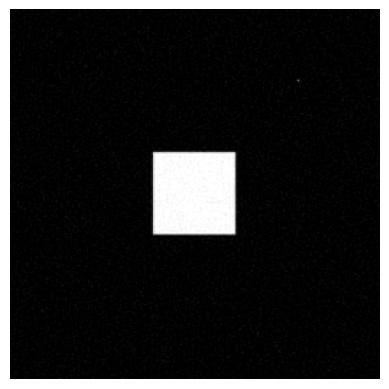

In [53]:
im_filtered = skio.imread('images/carre_flou.tif')
im_original = skio.imread('images/carre_orig.tif')

print('Original image :')
viewimage(im_original)
print('Filtered image :')
viewimage(im_filtered)


ker_tf = np.real(np.fft.ifft2(np.fft.fft2(im_filtered)/(np.fft.fft2(im_original)+1e-25)))
ker_tf_shifted = np.fft.fftshift(ker_tf)
print('Convolutional kernel :')
viewimage(ker_tf_shifted)

sigma_noise = 5
im_filtered_noisy = noise(im_filtered,sigma_noise)
print('Noisy filtered image :')
viewimage(im_filtered_noisy)
print('Wiener Restoration :')
viewimage(wiener(im_filtered_noisy,ker_tf_shifted,lamb=0.5))

This section improves Wiener restoration by using the spectral density of the degraded image and normalizing noise variance for enhanced accuracy.

New wiener restoration :


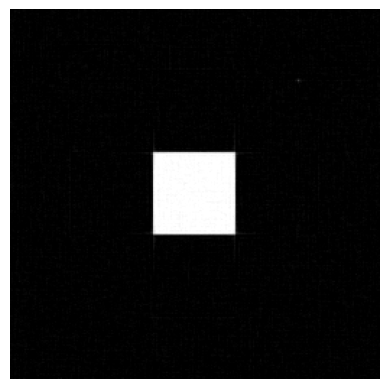

In [54]:
def wiener_modified(im,K,sb):
    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    (ty,tx)=im.shape
    (yK,xK)=K.shape
    KK=np.zeros((ty,tx))
    KK[:yK,:xK]=K
    x2=tx/2
    y2=ty/2
    

    g=fft2(im)
    k=fft2(KK)
    mul=np.conj(k)/(abs(k)**2+(sb**2)*tx*ty/(np.absolute(g)**2))
    fout=g*mul
    
    mm=np.zeros((ty,tx))
    y2=int(np.round(yK/2-0.5))
    x2=int(np.round(xK/2-0.5))
    mm[y2,x2]=1
    out=np.real(ifft2(fout*(fft2(mm))))
    return out

print('New wiener restoration :')
viewimage(wiener_modified(im_filtered_noisy,ker_tf_shifted,sigma_noise))